<a href="https://colab.research.google.com/github/praveenkumaresan/image-classification/blob/main/pk_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print("Path to dataset files:", path)


100%|██████████| 242M/242M [00:12<00:00, 20.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1


In [2]:
import os
from collections import defaultdict

# Set the path to your dataset directory
dataset_path = path

# Dictionary to store the count of images in each category
category_counts = defaultdict(int)

# Walk through the dataset directory to count the number of images in each category
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        image_count = len(os.listdir(category_path))
        category_counts[category] = image_count

# Print a summary of the dataset
print("Summary of the 5 Flower Types Classification Dataset:")
print("---------------------------------------------------")
for category, count in category_counts.items():
    print(f"Category: {category} - Number of Images: {count}")

print("\nTotal Categories:", len(category_counts))
print("Total Images:", sum(category_counts.values()))


Summary of the 5 Flower Types Classification Dataset:
---------------------------------------------------
Category: flower_images - Number of Images: 5

Total Categories: 1
Total Images: 5


**Image collage from the dataset**

Dataset downloaded to: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1


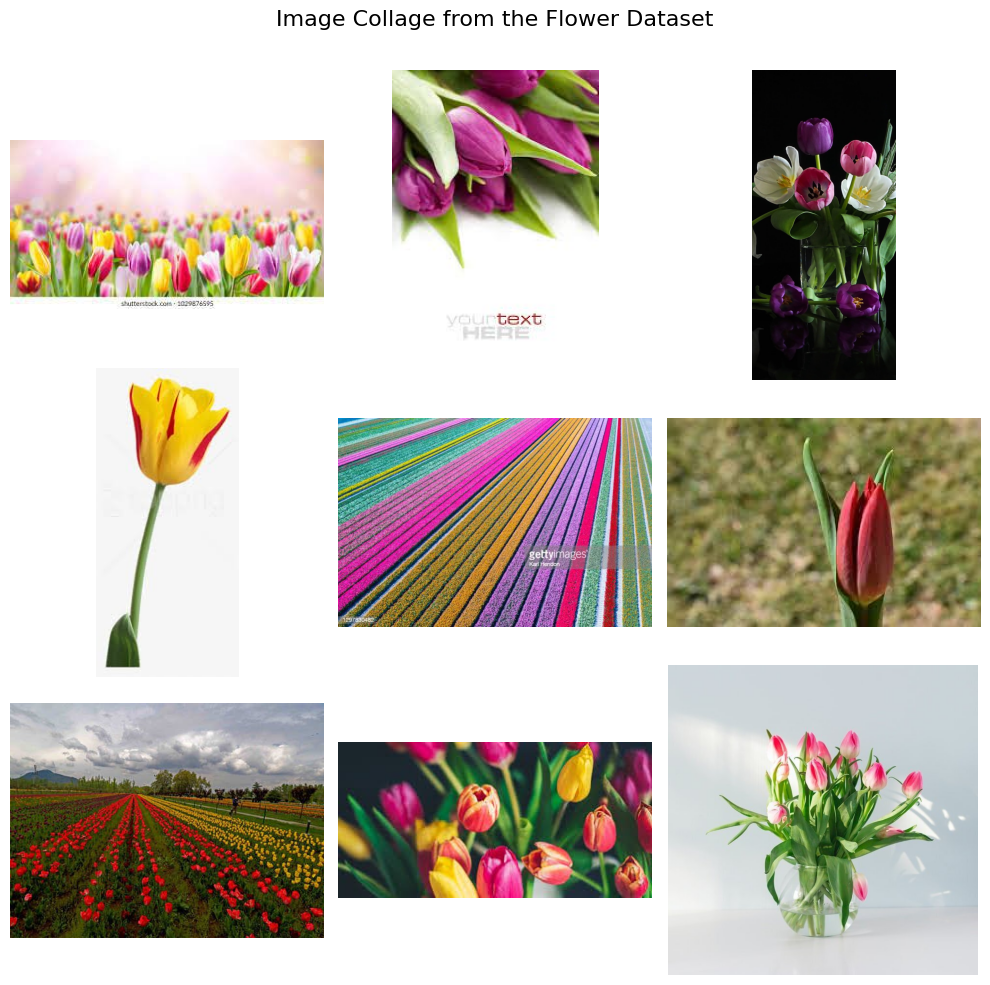

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub

# Print the path
print("Dataset downloaded to:", path)

# Collect all image paths from the dataset
image_extensions = ('.jpg', '.jpeg', '.png')
image_files = []

# Traverse through the directory to collect image files
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(image_extensions):
            image_files.append(os.path.join(root, file))

# Select a random sample of 9 images for the collage
sample_size = min(9, len(image_files))
sample_images = image_files[:sample_size]

# Create a 3x3 image collage
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Image Collage from the Flower Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    try:
        img = Image.open(sample_images[i])
        ax.imshow(img)
        ax.axis('off')
    except Exception as e:
        ax.set_title("Error loading image")
        ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


# Custom CNN

#### Split the dataset into test, training and validation

In [5]:
import os
import shutil
import random

# Set paths to your main image directory and where you want to store the splits
original_dataset_dir = path
base_dir = path

# Create directories for training, validation, and test sets
os.makedirs(os.path.join(base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test'), exist_ok=True)

# Split ratio (e.g., 70% for training, 15% for validation, 15% for test)
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Iterate over each class in the dataset
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)

    if os.path.isdir(class_dir):
        # Get a list of all image files in this class (skip directories)
        images = [file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))]
        random.shuffle(images)  # Shuffle the images randomly

        # Calculate the number of images for each split
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        validation_count = int(total_images * validation_ratio)

        # Create class directories in train, validation, and test folders
        os.makedirs(os.path.join(base_dir, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'validation', class_name), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'test', class_name), exist_ok=True)

        # Copy images to the respective directories
        for i, image in enumerate(images):
            src_path = os.path.join(class_dir, image)
            if i < train_count:
                dest_path = os.path.join(base_dir, 'train', class_name, image)
            elif i < train_count + validation_count:
                dest_path = os.path.join(base_dir, 'validation', class_name, image)
            else:
                dest_path = os.path.join(base_dir, 'test', class_name, image)

            shutil.copy(src_path, dest_path)

print("Images successfully split into training, validation, and test sets.")


Images successfully split into training, validation, and test sets.
